<a href="https://colab.research.google.com/github/mcroning/PRProp3D/blob/main/PRcoupler_large_videos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3D photorefractive steady state and time dependent beam propagation code

In [2]:
import numpy as np
import cupy as cp
from cupy import NaN
from cupyx.scipy.ndimage import zoom, gaussian_filter
import cupyx.scipy.fft as spfft
from scipy.signal.windows import tukey

#modules for input setup
import matplotlib.pyplot as plt
from PIL import Image, ImageChops
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

#modules for file management, input and output
import json
from pathlib import Path

#module for timing and benchmarking

from tqdm import tqdm

# modules for output display
from scipy.optimize import curve_fit
import matplotlib.animation as animation
from matplotlib.patches import Circle
from matplotlib import rcParams



first_run=True
parameters_initialized=False

In [3]:
# @title Define functions

def params(value,description,description_tooltip,disabled):
  """
  generate widgets for input float parameters
  Args:
    value: default value
    description: widget description
    description_tooltip: widget tooltip also variable name
    disabled: widget disabled

  Returns:
    widg: widget

  """
  prdata[description_tooltip]=value
  style={'description_width':'initial'}
  widg=widgets.FloatText(value=value,description=description,
                         description_tooltip=description_tooltip,disabled=disabled,style=style)
  def on_value_change(change):
    prdata[description_tooltip]=change['new']
  widg.observe(on_value_change,names='value')
  return widg
def intparams(value,description,description_tooltip,disabled):
  """
  generate widgets for input integer parameters
  Args:
    value: default value
    description:  widget description
    description_tooltip:  widget tooltip also variable name
    disabled: widget disabled

  Returns:
    widg: widget
  """
  prdata[description_tooltip]=value
  style={'description_width':'initial'}
  widg=widgets.IntText(value=value,description=description,
                       description_tooltip=description_tooltip,
                       disabled=disabled,style=style)
  #display(widg)
  def on_value_change(change):
    prdata[description_tooltip]=change['new']
  widg.observe(on_value_change,names='value')
  return widg
def checkbox(value,description,description_tooltip,disabled):
  """
  generate widgets for input boolean parameters
  Args:
    value:  default value (True or False)
    description:      widget description
    description_tooltip:  widget tooltip also variable name
    disabled: widget disabled

  Returns:
    widg: widget
  """

  prdata[description_tooltip]=value
  style={'description_width':'initial'}
  widg=widgets.Checkbox(value=value,description=description,
                        description_tooltip=description_tooltip,
                        disabled=disabled,style=style)
  def on_value_change(change):
    prdata[description_tooltip]=change['new']
  widg.observe(on_value_change,names='value')
  return widg
def dropdown(option,value,description,disabled,description_tooltip):
  """
  generate widgets for input dropdown parameters
  Args:
    option: list of options
    value:  default value
    description: widget description
    disabled:  widget disabled
    description_tooltip:  widget tooltip also variable name

  Returns:
    widg: widget
  """

  prdata[description_tooltip]=value
  style={'description_width':'initial'}
  widg=widgets.Dropdown(
    options=option,
    value=value,
    description=description,
    disabled=False,description_tooltip=description_tooltip,style=style
  )
  def on_value_change(change):
    prdata[description_tooltip]=change['new']
  widg.observe(on_value_change,names='value')
  #display(widg)
  return widg

def text_entry(value,placeholder,description,description_tooltip,disabled):
  """
  generate widgets for input text parameters
  Args:
    value: default value
    placeholder:  widget text box placeholder
    description:  widget description
    description_tooltip:  widget tooltip also variable name
    disabled: widget disabled

  Returns:
    widg: widget
  """
  prdata[description_tooltip]=value
  style={'description_width':'initial'}
  widg=widgets.Text(value=value,placeholder=placeholder,description=description,
                         description_tooltip=description_tooltip,disabled=disabled,style=style)
  def on_value_change(change):
    prdata[description_tooltip]=change['new']
  widg.observe(on_value_change,names='value')
  return widg

#ampxz: transverse amplitude cross section sampleed every fourth step (complex) [nsteps//4,xsamp,ysamp]
#imout_final: square sample of output on beam 1 (positive frequencies) (currently size yaper/2)
#imin: input intensity matching imout_final
#gain: calculated coupling gain for two beam coupling
#ift: far field intensity (float) [nsteps,xsamp,ysamp]
#prdata: dictionary containing variables and parameters

def genrot(rlen,thout,phi,x,y):
  """

  Args:
    rlen: crystal length (um)
    thout: beam input polar angle radians, 0 for normal incidence
    phi: beam azimuth, zero for beam in xz plane
    x: crystal coordinates array 1D float
    y: crystal coordinates array 1D float

  Returns: rotated coordinates xp,yp,zp 1D arrays used in beam generator gaus

  """

  #generate coordinate frames rotated by input angles
  xs=len(x)
  ys=len(y)
  xp=cp.zeros((xs,ys))
  yp=cp.zeros((xs,ys))
  zp=cp.zeros((xs,ys))
  el=rlen/2.0 #half interaction length
  th=cp.arcsin(cp.sin(thout)/refin) #internal propagation angle
  sP=cp.sin(phi)
  cP=cp.cos(phi)
  st=cp.sin(th)
  ct=cp.cos(th)
  s2p=2*sP*cP
  c2p=cP**2-sP**2
  xp=x[:,None]+cP*(1-ct)*(-x[:,None]*cP+y[None,:]*sP)-el*cP*st
  yp=y[None,:]+sP*(1-ct)*(x[:,None]*cP-y[None,:]*sP)+el*sP*st
  zp=(-el)*ct+(-x[:,None]*cP+y[None,:]*sP)*st
  return xp,yp,zp

def gaus(coord,beam,arrin,w0x,w0y):
    """

    Args:
      x: input angle rotated x coordinate 1D array
      y: input angle rotated y coordinate 1D array
      z: input angle rotated z coordinate 1D array
      beam: beam number: 2 is pump for 2 beam coupling, 1 for beam 1 signal
      arrin: scaled input image 2D array
      w0x: beam waist in x
      w0y: beam waist in y

    Returns: amp: complex beam amplitude array

    """
    #apply image to gaussian beam focussing at longitudinal center of crystal
    # if called for by value in variable transp
    #x,y,z rotated coordinates, beam = beam number 1 or 2
    #w0x beam waist in x direction
    lm=prdata['lm']
    refin=prdata['refin']
    xsamp=int(prdata['xsamp']) ; ysamp=int(prdata['ysamp'])
    x,y,z=coord
    kin=refin*2*cp.pi/lm # wavenumber of beam inside crystal
    z0x=w0x**2*kin/2.0
    z0y=w0y**2*kin/2.0
    eta=(cp.arctan(z/z0x)+cp.arctan(z/z0y))/2
    #inverse radii of curvature
    rlxinv=z/(z**2+z0x**2)
    rlyinv=z/(z**2+z0y**2)
    #rlxinvmn=rlen/(rlen**2+z0x**2) #mean inverse radius of curvature
    wl2x=w0x**2*(1.0+(z/z0x)**2)
    wl2y=w0y**2*(1.0+(z/z0y)**2)
    wlxy=cp.sqrt((1.0+(z/z0x)**2)*(1.0+(z/z0y)**2))
    argx = (x**2)*(1.0/wl2x-1j*kin*rlxinv/2.0)
    argy = (y**2)*(1.0/wl2y-1j*kin*rlyinv/2.0)
    arg=argx+argy
    # w0x<0 is a switch for plane wave input
    if w0x > 0:
      amp1 = cp.exp(-arg+1j*kin*z-1j*eta)/cp.sqrt(wlxy)
    else:
      amp1 = cp.exp(+1j*kin*z)

    if beam == 1:
      transp=prdata['transp1']
    else:
      transp=prdata['transp2']

    phasetransp=prdata['realimage']=="phase image"  #apply data as phase transparency if false
    # beam may have the data transparency imposed
    if transp:
      #find beam centers
      lenx,leny=cp.shape(arrin)
      xindex1,yindex1=getx0y0(coord)
      # avoidimage magnification taking arrays out of bounds
      ampxlo=max(xindex1-lenx//2,0)
      ampylo=max(yindex1-leny//2,0)
      ampxhi=min(xindex1+lenx//2,xsamp-1)
      ampyhi=min(yindex1+leny//2,ysamp-1)
      arrxlo=lenx//2-(xindex1-ampxlo)
      arrxhi=lenx//2+ampxhi-xindex1
      arrylo=leny//2-(yindex1-ampylo)
      arryhi=leny//2+ampyhi-yindex1


      if not phasetransp:
        amp1[ampxlo:ampxhi,ampylo:ampyhi] \
          = cp.sqrt(arrin[arrxlo:arrxhi,arrylo:arryhi]) \
          *amp1[ampxlo:ampxhi,ampylo:ampyhi]
      else:
        amp1[ampxlo:ampxhi,ampylo:ampyhi] \
          = cp.exp(1j*cp.pi*arrin[arrxlo:arrxhi,arrylo:arryhi]) \
          *amp1[ampxlo:ampxhi,ampylo:ampyhi]


    return amp1

def a(arrin,coord1,coord2):
    """

    Args:
      arrin: scaled input image 2D array
      coord1: rotated coordinates for beam 1 2D array
      coord2: rotated coordinates for beam 2 2D array
    Returns: full input field amplitude

    """
    rat=prdata['rat'] #beam ratio
    #a1r=1.0/cp.sqrt(1.0+rat)
    #a2r=cp.sqrt(rat)/cp.sqrt(1.0+rat)
    a1r=cp.sqrt(1.0/(1.0+rat))
    a2r=cp.sqrt(rat/(1.0+rat))


    # for the moment the beams have equal waists in x and y
    w0x1=prdata['w01']
    w0y1=prdata['w01']
    w0x2=prdata['w02']
    w0y2=prdata['w02']
    # generate beams 1 and 2
    amp1=gaus(coord1,1,arrin,w0x1,w0y1)
    amp2=gaus(coord2,2,arrin,w0x2,w0y2)
    # add them according to beam ratio
    atot=a1r*amp1+a2r*amp2
    return atot
def getx0y0(coord):
  """

  Args:
    xp: input angle rotated x coordinates 1D array
    yp: input angle rotated y coordinates 1D array

  Returns: array indices at center of input beams 1 and 2

  """
  xp1=coord[0]
  yp1=coord[1]
  #find beam centers where xp and yp are zero
  x0,y0=cp.unravel_index(cp.argmin(xp1**2+yp1**2),(xsamp,ysamp))
  return (int(x0),int(y0))
def hidiff(ift):
  """
  Diagnostic to determine importance of artifact diffraction orders
  Arg:
    ift: far field intensity array

  Returns: fraction of output in 2nd order non Bragg matched beams

  """
  # routine to determine importance of artifact diffraction orders
  xsamp=int(prdata['xsamp']) ; ysamp=int(prdata['ysamp'])
  xaper=prdata['xaper'] ; yaper=prdata['yaper']
  thout1=prdata['thout1'] ; thout2=prdata['thout2']
  phi1=prdata['phi1'] ; phi2=prdata['phi2']
  lm=prdata['lm']
  w01=prdata['w01']
  if w01 > 0:
    iwx=round(xaper/w01)
  else:
    iwx=4
  if w02 > 0:
    iwy=round(yaper/w01)
  else:
    iwy=4
  fx1=-np.cos(phi1)*np.sin(thout1)/lm
  fy1=np.sin(phi1)*np.sin(thout1)/lm
  fx2=-np.cos(phi2)*np.sin(thout2)/lm
  fy2=np.sin(phi2)*np.sin(thout2)/lm
  fx0=-xsamp/xaper/2 ; fy0=-ysamp/yaper/2
# p1,p2 indices of beam 1,2 in Fourier transform array
# p11,p21 indices of 1st higher order diff inbeam 1,2 in Fourier transform array
  p1=np.array((round((fx1-fx0)*xaper),round((fy1-fy0)*yaper)))
  p2=np.array((round((fx2-fx0)*xaper),round((fy2-fy0)*yaper)))
  p11=np.array((round((2*fx1-fx2-fx0)*xaper),round((2*fy1-fy2-fy0)*yaper)))
  p21=np.array((round((2*fx2-fx1-fx0)*xaper),round((2*fy2-fy1-fy0)*yaper)))
  s1=np.sum(ift[p1[0]+1-iwx:p1[0]+1+iwx,p1[1]+1-iwy:p1[1]+1+iwy])
  s11=np.sum(ift[p11[0]+1-iwx:p11[0]+1+iwx,p11[1]+1-iwy:p11[1]+1+iwy])
  s2=np.sum(ift[p2[0]+1-iwx:p2[0]+1+iwx,p2[1]+1-iwy:p2[1]+1+iwy])
  s21=np.sum(ift[p21[0]+1-iwx:p21[0]+1+iwx,p21[1]+1-iwy:p21[1]+1+iwy])
  hi_order_in_range_x= (iwx < p11[0] < (xsamp - iwx)) and (iwx < p21[0] < (xsamp - iwx))
  hi_order_in_range_y= (iwy < p11[1] < (ysamp - iwy)) and (iwy < p21[1] < (ysamp - iwy))

  #return fraction of artifact diffraction in output
  if hi_order_in_range_x and hi_order_in_range_y:
    return (s11+s21)/(s1+s2+s11+s21)
  else:
    return -1

  #return cp.sum(ddt**2)


def esc_f(amp,fx,k0):
  """

  Static space charge: Simple version
  Args:
    amp: optical amplitude 2D complex array
    fx: array of spatial frequencies to generate spatial derivatives in FT space
    k0: characteristic space charge wave number

  Returns: space charge field

  """

  # full steady state space charge field
  intens2=abs(amp)**2
  id=prdata['Id']
  Ip=cp.real(spfft.ifft(1.0j*2*cp.pi*fx[:,None]*spfft.fft(intens2,axis=0),axis=0))/k0
  esc=-cp.real(spfft.ifft(-spfft.fft(Ip/(intens2+id),axis=0)/
   (1+(2.0*cp.pi*fx[:,None]/k0)**2),axis=0) )
  return esc

def esc_s(amp,fx,k0):
  """
  Static space charge: Simple version for plane waves
  Args:
    amp: optical amplitude 2D complex array
    fx: array of spatial frequencies to generate spatial derivatives in FT space
    k0: characteristic space charge wave number

  Returns: space charge field

  """
  #simple steady state space charge field
  intens2=abs(amp)**2
  Ip=cp.real(spfft.ifft(1.0j*2*cp.pi*fx[:,None]*spfft.fft(intens2,axis=0),axis=0))/k0
  return Ip/(1+(kg/k0)**2)

def dEdt_s(amp,fx,k0,escsa):
  """
  Time derivative of space charge field: simplified version linear in space
  charge field. For plane waves only.
  Args:
    amp: optical amplitude 2D complex array
    fx: array of spatial frequencies to generate spatial derivatives in FT space
    k0: characteristic space charge wave number
    escsa: space charge field

  Returns: time derivative of space charge field

  """
  intens2=abs(amp)**2
  # kg grating wavenumber
  kg=2*np.pi*(np.sin(prdata['thout1']-np.sin(prdata['thout2'])))/prdata['lm']
  Ip=cp.real(spfft.ifft(1.0j*2*cp.pi*fx[:,None]*spfft.fft(intens2,axis=0),axis=0))/k0
  return -escsa*(1+(kg/k0)**2) + Ip

def dEdt_f(amp,fx,k0,escsa):
  """
  Full theoretical time derivative of space charge field:
  Args:
    amp: optical amplitude 2D complex array
    fx:  array of spatial frequencies to generate spatial derivatives in FT space
    k0:  characteristic space charge wave number
    escsa: space charge field

  Returns: time derivative of space charge field

  """
  intens2=abs(amp)**2
  Ip=cp.real(spfft.ifft(1.0j*2*cp.pi*fx[:,None]*spfft.fft(intens2,axis=0),axis=0))/k0
  escft=spfft.fft(escsa,axis=0)
  # Calculate transverse derivative of space charge field from previous step
  escsp=cp.real(spfft.ifft((2j*cp.pi*fx[:,None]/k0)* escft ,axis=0))
  # Calculate second derivative of space charge field from previous step
  escspp=cp.real(spfft.ifft((2j*cp.pi*fx[:,None]/k0)**2* escft ,axis=0))
  ddt_raw = -((escsa*(intens2+Id)-Ip)*(1+escsp)-escspp*(intens2+Id))
  return ddt_raw


def dn_calc(escsa,amp):   ###simplified here in PRcoupler2
  """
  Photorefractive nonlinearity
  Args:
    escsa: space charge field
    kout: optical wavenumber outside crystal (refractive index 1)
    kt: Kerr coefficient, perhaps thermal. Not tested

  Returns: nonlinear refactive index grating (2D real array)

  """
  intens2=abs(amp)**2
  kt=prdata['kt']
  kout=2*cp.pi/prdata['lm']
  gl=prdata['gl'];rlen=prdata['rlen']
  dn = -escsa*2*gl/(rlen*kout)+kt*intens2*1e-3 #photorefractive index array
  return dn

def noisexy(m):
  """
  scattering noise in x and y directions
  Args:
    m:seed with which to generate scattering noise

  Returns: corrnoise1layer 2D float array

  """
  xsamp=int(prdata['xsamp']) ; ysamp=int(prdata['ysamp']) ; yaper=prdata['yaper']
  xaper=prdata['xaper'] ; sigma=prdata['sigma'] ; eps=prdata['eps']
  rlen=prdata['rlen'] ; dz=prdata['dz']
  seeds=np.array(prdata['seeds'])
  niter=int(rlen/dz)
  sigmax=sigma*xsamp/xaper
  sigmay=sigma*ysamp/yaper
  cp.random.seed(seeds[m])
  corrnoise1layer_a=cp.random.normal(loc=0,scale=np.sqrt(eps/niter*4*np.pi),size=(xsamp,ysamp))
  corrnoise1layer=gaussian_filter(corrnoise1layer_a,sigma=(sigmax,sigmay))*cp.sqrt(sigmax*sigmay)
  return corrnoise1layer



In [4]:
# @title Load sample images and set parameters
#  Connect to Github for sample images
if not Path("/content/PRProp3D/images").exists():
  !git clone https://github.com/mcroning/PRProp3D


#prdata={} # parameter dictionary
data_file_name=""

if first_run:
  load_existing=input("Do you want to load existing parameters from Google Drive \n \
   if no, defaults will be used: y or n:")
else:
  load_existing=input("Do you want to load existing parameters from Google Drive \n \
   if no, values in widgets will be used: y or n:")

load_success=False
if load_existing in ("y","Y","Yes","YES"):
  from google.colab import drive
  drive.mount('/content/drive')
  data_file_name=input("enter starting parameter file (json or npz): ")
# Load parameters from npz file if needed

  if data_file_name != "":
    if Path(data_file_name).suffix==".npz":
      prdata=np.load(data_file_name,allow_pickle=True)["arr_0"].item()
      load_success=True
      first_run=False
    elif Path(data_file_name).suffix==".json":
      with open(data_file_name) as f:
        prdata=json.load(f)
      load_success=True
      first_run=False
    else:
      print("unknown file type")
      load_existing=False

  if load_success:
    for item in prdata:
      value=prdata[item]
      varname=item
      if type(value)==str:
        exec('%s = "%s"' % (varname,value))
      elif type(value)==int:
        exec('%s = %d' % (varname,value))
      elif type(value)==bool:
        exec('%s = %s' % (varname,value))
      elif item=='seeds':
        seeds=np.array(prdata['seeds'])

      elif type(value)==float:
        exec('%s = %f' % (varname,value))

if first_run:
  prdata={'gl': -3.0,
 'rat': 1,
 'image_on_beam': 'No Image',
 'realimage': 'real image',
 'image_size_factor': 1,
 'external_image': '',
 'std_image': 'MNIST 0',
 'image_invert': False,
 'noisetype': 'none',
 'sigma': 0.4,
 'eps': 0.02,
 'kt': 0.0,
 'xaper': 1000,
 'yaper': 1000,
 'xsamp': '4096',
 'ysamp': '512',
 'rlen': 4000,
 'dz': 20,
 'lm': 0.633,
 'w01': 100,
 'w02': 100,
 'Eplane': False,
 'thout1': 0.1,
 'thout2': -0.1,
 'phi1': 0,
 'phi2': 0,
 'backpropagate': False,
 'time_behavior': 'Static',
 'tend': 10.0,
 'tsteps': 120,
 'use_cons_tsteps': False,
 'batchnum_spec': 1,
 'fanning_study': False,
 'use_old_seeds': False,
 'folder': '',
 'savedata': False,
 'epsr': 2500,
 'NT': 6.4e+22,
 'T': 293,
 'refin': 2.4,
 'Id': 0.01,
 'windowedge': 0.1,
 'seeds':[]
          }
# initialize parameters:

first_run=False

#set up input widgets
standard_images=["MNIST 0", "MNIST 1", "MNIST 2", "MNIST 3", "MNIST 4", "MNIST 5", "MNIST 6", "MNIST 7", "MNIST 8", "MNIST 9", "AF Res Chart"]
xsamples=["1024", "2048", "4096", "8192", "16384","32768"]
ysamples=["256", "512", "1024", "2048","4096"]

style={'description_width':'initial'}

gl_=params(prdata['gl'],'gain length product','gl',False)
rat_=params(prdata['rat'],'beam ratio','rat',False)
im_on_beam=dropdown(['No Image','Beam 1','Beam 2','Beams 1 & 2'],
                    prdata['image_on_beam'],'image on beam',False,'image_on_beam')
im_type=dropdown(['real image', 'phase image'],prdata['realimage'],
                 'image type',False,'realimage')
im_size_norm=params(prdata['image_size_factor'],'image size norm by waist',
                    'image_size_factor',False)
external_im=text_entry(prdata['external_image'],'Insert text here','external image file','external_image',False)
std_im=dropdown(standard_images,prdata['std_image'],'standard image',False,'std_image')
im_invert=checkbox(prdata['image_invert'],'invert image','image_invert',False)
noisetype_=dropdown(["none","volume xy"],prdata['noisetype'],'noise type',False,'noisetype')
sigma_=params(prdata['sigma'],'scattering correlation length','sigma',False)
volnoise=params(prdata['eps'],'volume noise parameter','eps',False)
kerr_coeff=params(prdata['kt'],'Kerr coefficient','kt',False)
xaper_=params(prdata['xaper'],'x aperture um','xaper',False)
yaper_=params(prdata['yaper'],'y aperture um','yaper',False)
xsamp_=dropdown(xsamples,str(prdata['xsamp']),'x samples',False,'xsamp')
ysamp_=dropdown(ysamples,str(prdata['ysamp']),'y samples',False,'ysamp')
int_len=params(prdata['rlen'],'interaction length','rlen',False)
dz_=params(prdata['dz'],'z step size um','dz',False)
lm_=params(prdata['lm'],'wavelength um','lm',False)
w1=params(prdata['w01'],'waist 1','w01',False)
w2=params(prdata['w02'],'waist 2','w02',False)


plane_model=checkbox(prdata['Eplane'],'use plane wave space charge model if appropriate','Eplane',False)
th1=params(prdata['thout1'],'beam 1 polar angle','thout1',False)
th2=params(prdata['thout2'],'beam 2 polar angle','thout2',False)
az1=params(prdata['phi1'],'azimuth 1','phi1',False)
az2=params(prdata['phi2'],'azimuth 2','phi2',False)
bkp=checkbox(prdata['backpropagate'],'backpropagate output image','backpropagate',False)
t_beh=dropdown(["Static", "Time Dependent"],
              prdata['time_behavior'],'time behavior',False,'time_behavior')
end_time=params(prdata['tend'],'end time (t0)','tend',False)
tsteps_=intparams(prdata['tsteps'],'time steps','tsteps',False)
use_cons_tsteps_=checkbox(prdata['use_cons_tsteps'],'use conservative time steps','use_cons_tsteps',False)
numbatch=intparams(prdata['batchnum_spec'],'number of batches','batchnum_spec',False)
fanning_study_=checkbox(prdata['fanning_study'],'fanning study','fanning_study',False)
use_old_seeds_=checkbox(prdata['use_old_seeds'],'use old seeds','use_old_seeds',False)
gdrive_folder=text_entry(prdata['folder'],'Insert text here','Google drive folder','folder',False)
save_output=checkbox(prdata['savedata'],'save output','savedata',False)
epsr_=params(prdata['epsr'],'relative dielectric constant','epsr',False)
charge_dens=params(prdata['NT'],'mobile charge density','NT',False)
temperature=params(prdata['T'],'temperature K','T',False)
index=params(prdata['refin'],'refractive index','refin',False)
dark_intensity=params(prdata['Id'],'dark intensity','Id',False)
tukey_edge=params(prdata['windowedge'],'Tukey window edge','windowedge',False)

vbox_left=widgets.VBox([gl_,rat_,im_on_beam,im_type,im_size_norm,external_im,
                        std_im,im_invert,noisetype_,sigma_,volnoise,kerr_coeff,
                        xaper_,yaper_,xsamp_,ysamp_,int_len,dz_,lm_,w1,w2
                        ])
vbox_right=widgets.VBox([plane_model,th1,th2,az1,az2,bkp,t_beh,end_time,tsteps_,
                        use_cons_tsteps_,numbatch,fanning_study_,
                        use_old_seeds_,gdrive_folder,save_output,epsr_,charge_dens,
                        temperature,index,dark_intensity,tukey_edge])
hbox=widgets.HBox([vbox_left,vbox_right])
display(hbox)





Do you want to load existing parameters from Google Drive 
    if no, defaults will be used: y or n:n


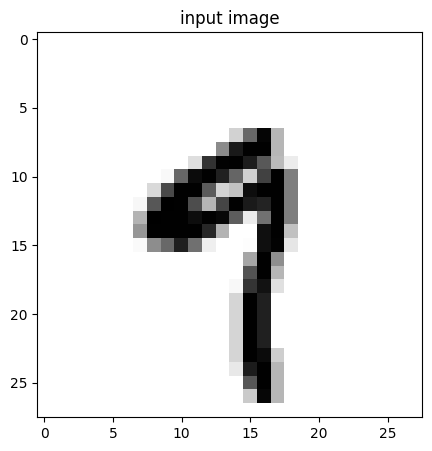

In [9]:
# @title Initialize parameters and arrays using widget entries: this may take a couple of minutes.
gl=gl_.value
rat=rat_.value
image_on_beam=im_on_beam.value
realimage=im_type.value
image_size_factor=im_size_norm.value
external_image=external_im.value
std_image=std_im.value
image_invert=im_invert.value
noisetype=noisetype_.value
sigma=sigma_.value
eps=volnoise.value
kt=kerr_coeff.value
xaper=xaper_.value
yaper=yaper_.value
xsamp=int(xsamp_.value)
ysamp=int(ysamp_.value)
rlen=int_len.value
dz=dz_.value
lm=lm_.value
w01=w1.value
w02=w2.value
Eplane=plane_model.value
thout1=th1.value
thout2=th2.value
phi1=az1.value
phi2=az2.value
backpropagate=bkp.value
time_behavior=t_beh.value
tend=end_time.value
tsteps_set=tsteps_.value
use_cons_tsteps=use_cons_tsteps_.value
batchnum_spec=numbatch.value
fanning_study=fanning_study_.value
use_old_seeds=use_old_seeds_.value
folder=gdrive_folder.value
savedata=save_output.value
epsr=epsr_.value
NT=charge_dens.value
T=temperature.value
refin=index.value
Id=dark_intensity.value
windowedge=tukey_edge.value
a0=1e-3 #tukey window absorption coefficient in um^-1

if  w01 > 0 or w02 > 0: #only use plane wave grating theory when appropriate.
  Eplane=False
  plane_model.value=False
  prdata['Eplane']=False
else:  #we are using plane waves, so force periodic conditions
  fc=xsamp*lm/2/xaper
  thout1=np.arcsin(fc/(2**round(np.log(fc/np.sin(abs(thout1)))/np.log(2))))*np.sign(thout1)
  thout2=-thout1
  th1.value=thout1
  th2.value=thout2
  thout1=th1.value
  thout2=th2.value

if Eplane:
  dEdt = dEdt_s
  esc = esc_s
else:
  dEdt = dEdt_f
  esc = esc_f

warning=""

transp2=image_on_beam==("Beam 2" or "Beams 1 & 2")
transp1=image_on_beam==("Beam 1" or "Beams 1 & 2")
prdata['transp1']=transp1
prdata['transp2']=transp2
timedep=prdata['time_behavior']=="Time Dependent"
prdata['timedep']=timedep

q=1.602e-19 #magnitude of charge on electron
eps0=8.854e-12 #dielectric constant of free space
kB=1.380649e-23 #Boltzmann's constant

k0=q*np.sqrt(NT/(epsr*eps0*kB*T))*1e-6 #characteristic photorefractive wavenumber
kg=2*np.pi*(np.sin(thout1)-np.sin(thout2))/lm #grating wave number
kg_norm=kg/k0
Es=q*NT/(epsr*eps0*k0*1e6)             #characteristic space charge field
kout=2*np.pi/lm      #external wavenumber

niter=int(rlen/dz)
batchsize=niter//batchnum_spec # number of xy planes in each batch
nbatches=niter//batchsize  #actual number of batches that will fit in niter dz steps

########################################  Image setup code below
image_in_def=cp.ones((28,28),dtype=np.uint8) #default image
image_in=image_in_def
#make room for single display of image to be placed on beam
if 'figimin' in locals():
  figimin.clear()
#try:
#  figimin.clear()
#except:
#  pass

if prdata['external_image'] !=  "":
  image_file_name=prdata['external_image']
else:
  match prdata['std_image']:
    case "MNIST 0":
      image_file_name = "/content/PRProp3D/images/mnist0.png"
    case "MNIST 1":
      image_file_name = "/content/PRProp3D/images/mnist1.png"
    case "MNIST 2":
      image_file_name = "/content/PRProp3D/images/mnist2.png"
    case "MNIST 3":
      image_file_name = "/content/PRProp3D/images/mnist3.png"
    case "MNIST 4":
      image_file_name = "/content/PRProp3D/images/mnist4.png"
    case "MNIST 5":
      image_file_name = "/content/PRProp3D/images/mnist5.png"
    case "MNIST 6":
      image_file_name = "/content/PRProp3D/images/mnist6.png"
    case "MNIST 7":
      image_file_name = "/content/PRProp3D/images/mnist7.png"
    case "MNIST 8":
      image_file_name = "/content/PRProp3D/images/mnist8.png"
    case "MNIST 9":
      image_file_name = "/content/PRProp3D/images/mnist9.png"
    case "AF Res Chart":
      image_file_name = "/content/PRProp3D/images/AF Res Chart.png"
if image_on_beam == 'No Image':
  image_file_name=""
prdata['image_file_name']=image_file_name
display_input_image=False
if (transp1==1 or transp2==1) and Path(image_file_name).exists(): #path.exists(image_file_os.name)
  prdata['image_file_name']=image_file_name
  display_input_image=True
  image_in = Image.open(image_file_name)
  if prdata['image_invert']:
    image_in=ImageChops.invert(image_in)
  image_in = cp.asarray(image_in)

  if np.ndim(image_in)==3: #color image to greyscale
      image_in=image_in.mean(axis=2)

imsizex=np.shape(image_in)[0]  #find original x dimension of image
imsizey=np.shape(image_in)[1]  #find original y dimension
maxsize=max(imsizex,imsizey)   #find maximum side length, maxsizenormint
if maxsize % 2 !=0: # make sure sides are of even length
        maxsize +=1
offset_x=-(imsizex-maxsize)//2
offset_y=-(imsizey-maxsize)//2

image_in_sq=cp.ones((maxsize,maxsize))*np.max(image_in)  # make square image matrix that will hold input omage
image_in_sq[:imsizex,:imsizey]=image_in #load potentiallly non square image ont quare image matrix
image_in_sq=np.roll(image_in_sq,offset_x,axis=0)
image_in_sq=np.roll(image_in_sq,offset_y,axis=1)
image_in=image_in_sq.astype(np.uint16) #
if display_input_image:
  figimin = plt.figure(figsize=(5, 5), dpi=100)
  iminax=figimin.add_subplot()

  iminax.imshow(image_in.get(),cmap='gray')
  iminax.set_title('input image')
image_in = cp.asarray(image_in)

# if w01 is less than 0 it is the beam is set to be a plane wave.
# if w01>0 the image is scaled to the size factor times waist of beam 1
if prdata['w01'] > 0:
# find zoom factor for image to place it on beam 1
  zoomsc=prdata['image_size_factor']*prdata['w01']/maxsize
else:
# if plane wave, image size is half of x aperture
  zoomsc=prdata['image_size_factor']*xaper/2/maxsize
#scale and normalize to unity
arrin=(zoom(np.rot90(image_in),(zoomsc*xsamp/xaper,zoomsc*ysamp/yaper),order=0))
arrin=arrin/np.max(arrin)
arrin=cp.array(arrin)
########################## End of Image setup code, arrin is the final product
#x and y grid spacing, dx, dy
dx=xaper/xsamp
dy=yaper/ysamp
#maximum wavenumbers in Fourier space
fymax=ysamp/yaper/2
fxmax=xsamp/xaper/2
#central spatial freqiencies of input gaussians fx1,fx2,fy1,fy2
#input beams transverse central wave numbers
fx1=-np.cos(phi1)*np.sin(thout1)/lm
fy1=np.sin(phi1)*np.sin(thout1)/lm
fx2=-np.cos(phi2)*np.sin(thout2)/lm
fy2=np.sin(phi2)*np.sin(thout2)/lm
warn1 = widgets.Output(layout={'border': '1px solid black'})
warn1.clear_output()
if not(-fxmax<fx1<fxmax and -fymax<fy1<fymax):
  with warn1:
    print('Warning: Beam 1 spatial frequencies became outside grid limits')
if not(-fxmax<fx2<fxmax and -fymax<fy2<fymax):
   with warn1:
    print('Warning: Beam 2 spatial frequencies became outside grid limits')
if xsamp*ysamp*rlen/dz > 8192*256*400*batchnum_spec and timedep:
  with warn1:
    print('grid dimensions exceed V100 GPU capacity for time dependent calculation.' )
if xsamp*ysamp*rlen/dz > 4096*2048*4000/12.5*batchnum_spec and timedep:
  with warn1:
    print('grid dimensions exceed A100 GPU capacity for time dependent calculation.' )
ff_vmax=None #scale for output far field

#initialize arrays
# The input beams are two gaussian beams labeled beam 1 and beam 2
# which cross at the center of the crystal. Beam 1 generally
# travels with negative spatial frequency, when its angle is specified
# as positive.
# The input profiles of each beam are calculated using coodinate systems
# rotated about the center of the crytals by the internal polar and azimuthal
# propagation angles th1,phi1 and th2,phi2 (to account for
# refraction at the crystal surface). The field for beam 1 at crystal
# coordinate (x,y,z=0) is calculated using the corresponding coordinate
# (xp1,yp1,zp1) in the frame where the xp-yp plane is perpendicular to
# the direction of propagation of beam 1. This rotated coordinate is fed
# to the function gaus, defined below, which calculates a gaussian profile
# using the usual formula
# modelling frame coordinates (eg photorefractive crystal)

x=cp.linspace(-xaper/2,xaper/2,xsamp,endpoint=False)
y=cp.linspace(-yaper/2,yaper/2,ysamp,endpoint=False)
z=cp.linspace(0,rlen,niter)
# generate tuples of rotated coordinates
coord1=cp.asarray(genrot(rlen,thout1,phi1,x,y))
coord2=cp.asarray(genrot(rlen,thout2,phi2,x,y))

# provide masks in fourier plane to enable separation of beams 1 and 2
mask1=np.zeros((xsamp,ysamp))
Fyj=(np.arange(ysamp)-ysamp//2)/yaper
Fxk=(np.arange(xsamp)-xsamp//2)/xaper
DF1=(Fxk[:,None]-fx1)**2+(Fyj[None,:]-fy1)**2
DF2=(Fxk[:,None]-fx2)**2+(Fyj[None,:]-fy2)**2
mask1=np.where(DF1<=DF2,1,0)
mask1=cp.fft.fftshift(mask1)
mask1=cp.asarray(mask1)
# fanning studies are designed to be on input beam 1
if fanning_study:
  if w01 > 0:
    # find zoom factor for image to place it on beam 1
    ws=min(w01,20) #minimum size of mask to cut remaining input beam
  else:
    # beam 1 is a plane wave
    ws=20

  maskxp=int(xaper*(fx1+1/ws/2))+xsamp//2
  maskxm=int(xaper*(fx1-1/ws/2))+xsamp//2
  maskyp=int(yaper*(fy1+1/ws/2))+ysamp//2
  maskym=int(yaper*(fy1-1/ws/2))+ysamp//2
  mask=np.ones((xsamp,ysamp))
  mask[maskxm:maskxp,maskym:maskyp]=0

# preprocess input image and generate input field


amp0=a(arrin,coord1,coord2) #load input field into GPU

# find information about negative and positive going beams (beam 1, beam2)
# needed for gain calculation in calculation loop
amp0p=cp.fft.ifft2(cp.fft.fft2(amp0)*(1-mask1))  #positive spatial frequency input field (beam 2 spatial frequencies)
amp0m=cp.fft.ifft2(cp.fft.fft2(amp0)*mask1)  #negative spatial frequency input field

im0r=cp.sum(cp.sum(abs(amp0m)**2))/cp.sum(cp.sum(abs(amp0)**2)) # normalized beam 2 power
ip0r=cp.sum(cp.sum(abs(amp0p)**2))/cp.sum(cp.sum(abs(amp0)**2)) # normalized beam 1 power



xl=(xsamp*(-yaper/xaper/2)) #xl(ow), xh(igh), x index offsets for square sample
# of output occupying half the y aperture yaper since yaper is usually < xaper
xh=(xsamp*(+yaper/xaper/2))
yl=(-ysamp/2) # yl, yh indices offset for square sample of output
yh=(ysamp/2)

if w01 < 0 or w02 < 0:
  w01s=100
else:
  w01s=w01

xl=max(-2*w01s,xl)
xh=min(2*w01s,xh)
yl=max(-2*w01s,yl)
yh=min(2*w01s,yh)
im_samp_width=min(2*w01s,xaper)
im_samp_height=min(2*w01s,yaper)

xl=((-im_samp_width/dx/2)) #xl(ow), xh(igh), x index offsets for square sample
# of output occupying half the y aperture yaper since yaper is usually < xaper
xh=((+im_samp_width/dx/2))
yl=(-im_samp_height/dy/2) # yl, yh indices offset for square sample of output
yh=(im_samp_height/dy/2)


x1ind,y1ind=getx0y0(coord1) #location indixes of centers of beam 1 and beam 2
x2ind,y2ind=getx0y0(coord2)
#set corner indices for image sample, making sure not to go out of bounds
xinmin0=float(max(0,int(xl+x1ind)))
xinmax0=float(min(xsamp,int(xh+x1ind)))
yinmin0=float(max(0,int(yl+y1ind)))
yinmax0=float(min(ysamp,int(yh+y1ind)))

xinmin=float(max(0,int(xl+xsamp-x1ind)))
xinmax=float(min(xsamp,int(xh+xsamp-x1ind)))
yinmin=float(max(0,int(yl+ysamp-y1ind)))
yinmax=float(min(ysamp,int(yh+ysamp-y1ind)))

# sample of negative frequencies (beam 1)
imcenter0=abs(amp0m[xinmin0:xinmax0,yinmin0:yinmax0])**2
lx,ly=cp.shape(imcenter0)
imin=imcenter0.get() #imin : input beam 1 intensity to cpu

#calculate linear propagator, without evanescent component
# sum of squares of spatial frequencies to use in propagator h
fx=cp.fft.fftfreq(xsamp,xaper/xsamp)
fy=cp.fft.fftfreq(ysamp,yaper/ysamp)
fxy=fx[:,None]**2+fy[None,:]**2
h=cp.where((lm/refin)**2*(fxy)<1.0,
           cp.exp(2.0j*cp.pi*refin*dz/lm*cp.sqrt(1-(lm/refin)**2*(fxy)))
           ,cp.exp(-2.0*cp.pi*refin*dz/lm*cp.sqrt(-1+(lm/refin)**2*(fxy))))

h=cp.where((lm/refin)**2*(fxy)<1.0,
           cp.exp(2.0j*cp.pi*refin*dz/lm*cp.sqrt(1-(lm/refin)**2*(fxy)))
           ,0)


##tukey windows for real space

windowx = tukey(xsamp,alpha=windowedge,sym=False)
windowy = tukey(ysamp,alpha=windowedge,sym=False)
windowxy = np.sqrt(np.outer(windowx,windowy))
windowxy=cp.asarray(windowxy)
#windowxy=1-a0*(1-windowxy)*dz   #new edge
fwindowxy=cp.fft.fftshift(windowxy)

# allocate storage for space charge field
if timedep:
  if nbatches == 1:
      escsfull=cp.zeros((niter,xsamp,ysamp),dtype=float)   #full 3D space charge field
      ####ddtprev=cp.zeros((niter,xsamp,ysamp),dtype=float)
  else:  #if multiple batches, allocate space for full xyz space charge arrays
      escsfull_cpu=np.zeros((niter,xsamp,ysamp),dtype=float)   #full 3D space charge field
      ####ddtprev_cpu=np.zeros((niter,xsamp,ysamp),dtype=float)
  escsp=cp.zeros((xsamp,ysamp),dtype=float)      #space charge x gradient
  escspp=cp.zeros((xsamp,ysamp),dtype=float)     #space charge 2nd derivative

# generate noise as needed

#sigma, noise correlation length microns, noiseamp amplitude of scatterers
#sigmax,y,z corresponding correlation length in terms of array units
sigmax=sigma*xsamp/xaper
sigmay=sigma*ysamp/yaper
sigmaz=sigma*niter/rlen #unused

if timedep==True:
    kmax=2*np.pi*fx[xsamp//2-1]/k0
    if use_cons_tsteps:
      deltat=1/4/kmax**2
    else:
      deltat=tend/tsteps_set
    tsteps=int(np.round(tend/deltat/4))*4 # make sure number of time steps is divisible by 4
    tsteps_set=tsteps
    tsteps_.value=tsteps
    prdata['tsteps']=tsteps
    t_seq=cp.linspace(deltat,tend,tsteps) # real fundamenatal time steps
    #t_seq=cp.linspace(deltat,tend*(1+(kg/k0)**2),tsteps)
    # for plotting temporal reponse in units of kg dependent time constant
    # tau=t0/(1+(kg/k0)**2)
    escsxz=cp.zeros((tsteps//4,niter,xsamp))
    ampout=cp.zeros((tsteps//4,xsamp,ysamp),dtype=complex)
    ampxz=cp.zeros((tsteps//4,niter,xsamp),dtype=complex)
else:
    tsteps=1

    escsxz=cp.zeros((1,niter,xsamp))
    ampout=cp.zeros((1,xsamp,ysamp),dtype=complex)
    ampxz=cp.zeros((1,niter,xsamp),dtype=complex)
prdata['tsteps']=tsteps
gain_seq=cp.zeros(tsteps)

#generate exponentially distributed propagation steps if needed

#imr_norm: amplified beam 1 power normalized to plane wave steady state
imr_norm=cp.zeros(tsteps)

if noisetype=='volume xy':
  if use_old_seeds:
    if len(prdata['seeds']) != 0:
      seeds=prdata['seeds']

    elif Path.exists(Path("noise_seeds.npy")):
      datain=np.load("noise_seeds.npy")
      seeds=np.asarray(datain)
    if len(seeds) != niter:
        print('old seeds imcompatible with number of iterations, generating new seeds')
        seeds=np.random.randint(0,2**32-1,size=niter).tolist()
    elif len(seeds) == 0:
      print('no old seeds, generating new seeds')
      seeds=np.random.randint(0,2**32-1,size=niter).tolist()
    else:
      print('old seeds loaded')

  else:
    seeds=np.random.randint(0,2**32-1,size=niter).tolist()
  prdata['seeds']=seeds
  np.save("noise_seeds",seeds)
else:
  seeds=[]

light_filter=cp.where(lm**2*(fx[:,None]**2+fy[None,:]**2)<1,fwindowxy,0)



if savedata:
  from google.colab import drive
  drive.mount('/content/drive')
  pathf='/content/drive/MyDrive/'+folder
  if not Path(pathf).is_dir():
    Path.mkdir(Path(pathf))

  #temporary google files
  pathf_temp='/content/drive/MyDrive/temp_files/'
  if not Path(pathf_temp).is_dir():
    Path.mkdir(Path(pathf_temp))
parameters_initialized=True

In [10]:
# @title Calculation loop
if  not parameters_initialized:
  print('parameters not initialized. Please run initialization cell above')
  abort=True
else:
  abort=False
parameters_initialized=False
#amp0=cp.ones((xsamp,ysamp))
#amp0=cp.where(x[:,None]**2+y[None,:]**2<1,1,0)
#amp0=cp.zeros((xsamp,ysamp))
#amp0[xsamp//2,ysamp//2]=1.0
amp0ft=spfft.fft2(amp0)
amp0ft=cp.where(lm**2*(fx[:,None]**2+fy[None,:]**2)<1,amp0ft,0)
amp0=spfft.ifft2(amp0ft)




for jt in tqdm(range(tsteps)):
    if abort==True:
      break
    #Set input field to amp0
    amp=amp0
    ampft=spfft.fft2(amp) #for first propagation step at each time step
    #begin z propagation

    jb=0 # base index of first batch
    #loop over all batches
    for j in range(nbatches):
      if abort==True:
        break
      if timedep and nbatches != 1:   #load batch  escs from cpu if more than one batch
        jb=j*batchsize
        escsfull=cp.asarray(escsfull_cpu[jb:jb+batchsize])

      #begin batch
      for i in range(batchsize): # total number of z steps (niter) if one batch
          if abort==True:
            break
          # linear diffraction of amplitude amp for one dz step
          # ampft is saved from previous step after 1st step
          amp=spfft.ifft2(ampft*h*fwindowxy)
          ampft=spfft.fft2(amp)

          if timedep:
            # time dependent
              #Euler one step evolution of space charge field
            escsfull[i] = escsfull[i] + deltat*dEdt(amp,fx,k0,escsfull[i])
              # calculate photorefractive index at current batch position
            dn = dn_calc(escsfull[i],amp)
              # apply dn to amp
            amp=amp*cp.exp(1.0j*kout*dn*dz)*windowxy
            if noisetype=='volume xy':
              # apply noise if called for
              noise_xy=noisexy(jb+i)
              amp=amp*cp.exp(1j*noise_xy)
            # check for instability in integration
            if cp.isnan(cp.sum(amp)) and abort==False:
              abort=True
              jt_last_good=jt-1
              if jt_last_good<0:
                jt_last_good=0
              print('aborted for time instability at ',jt)
          else:
            #Steady State
            escs=esc(amp,fx,k0)
            dn= dn_calc(escs,amp) #photorefractive index array
            amp=amp*cp.exp(1.0j*kout*dn*dz)*windowxy
            if noisetype=='volume xy':
              noise_xy=noisexy(jb+i)
              amp=amp*cp.exp(1j*noise_xy)
              #dn=dn+(noiseamp*corrnoise1layer+kt*intens2)*dz*1e-3    #kt a thermal contribution
          #end of propagation step

          #prepare output arrays and data for this step
          ampft=spfft.fft2(amp)
          ampm=spfft.ifft2(ampft*mask1)  #beam 1 intensity
          ampp=amp-ampm  #beam 2 intensity
          imr=cp.sum(cp.sum(abs(ampm)**2))/cp.sum(cp.sum(abs(amp)**2)) # normalized beam 2 total power
          ipr=cp.sum(cp.sum(abs(ampp)**2))/cp.sum(cp.sum(abs(amp)**2)) # normalized beam 1 total power
          imr_norm[jt]=imr*(1+rat*np.exp(2*gl)) #amplified beam 1 power normalized to plane wave steady state
            #gain calculated using plane wave formula
          gain_seq[jt]=-cp.log(imr/im0r/(ipr/ip0r)) /2
          if jt%4==0:
            ampxz[jt//4,j*batchsize+i,:]=amp[:,ysamp//2]  #store every 4th cross section and amplitude
            if timedep:
              escsxz[jt//4,j*batchsize+i,:]=escsfull[i,:,ysamp//2]  #store every 4th cross section and amplitude
            else:
              escsxz[jt//4,j*batchsize+i,:]=escs[:,ysamp//2]  #store every 4th cross section and amplitude
            ampout[jt//4]=amp # store every fourth time dependent amplitude
      if timedep and nbatches != 1:
          #update space charge field in cpu
        escsfull_cpu[jb:jb+batchsize]=escsfull.get()

    #end z step loop code at time step jt

      gain=-cp.log(imr/im0r/(ipr/ip0r))/2
      imcenter=abs(ampm[xinmin:xinmax,yinmin:yinmax])**2 #big sample of negative frequencies (beam 1)
      lx,ly=cp.shape(imcenter)
      if jt==0:
          ifts=(abs(cp.fft.fftshift(ampft))**2)
          ift=ifts
          imout=imcenter #imout : image out cpu
      elif jt%4==0:
          ifts=(abs(cp.fft.fftshift(ampft))**2)
          ift=cp.concatenate((ift,ifts))
          imout=cp.concatenate((imout,imcenter))
      #back propagate to see effect on image
      if backpropagate:  #please check for behavior if abort
          ampb=amp
          ampbft=spfft.fft2(ampb)
          for i in range(niter):

              ampbft=ampbft*cp.conj(h)
              ampb=spfft.ifft2(ampbft)*windowxy
          ampbft=spfft.fft2(ampb)
          ampbm=spfft.ifft2(ampbft*mask1)  #beam 1 intensity
          ampbp=ampb-ampbm  #beam 2 intensity
          imcenterb=abs(ampbm[xinmin0:xinmax0,yinmin0:yinmax0])**2 #big sample of beam 1
          lxb,lyb=cp.shape(imcenterb)
          if jt==0:
              imoutb=imcenterb
          elif jt%4==0:
              imoutb=cp.concatenate((imoutb,imcenterb))

#End t step loop
if not abort:
  jt_last_good=jt
if True:
  power_monitor=np.sum(abs(amp.get())**2)/np.sum(abs(amp0.get())**2)
  print('plane wave gain '+str(gl)+' calculated gain '+'{0:.3f}'.format(gain))
  if prdata['timedep']==True:

      ift=cp.reshape(ift,(np.size(ift)//(xsamp*ysamp),xsamp,ysamp))
  else:

      ift=cp.reshape(ift,(1,xsamp,ysamp))


  print('high order diffraction',hidiff(ift[-1]))
  print('if -1 then 2nd order diffractions are out of current Fourier space')

  print('total output power normalized to input power',power_monitor)
  if fanning_study:
    faneff=np.sum(mask*ift.get(),axis=(1,2))/np.sum(ift.get(),axis=(1,2))
    print('fanning efficiency',faneff[-1])



100%|██████████| 32/32 [00:23<00:00,  1.36it/s]

plane wave gain -3.0 calculated gain -1.289
high order diffraction 5.915072122490131e-06
if -1 then 2nd order diffractions are out of current Fourier space
total output power normalized to input power 0.9993887540834597


interactive(children=(FloatSlider(value=7.054146019322111, description='far_field_max', max=14.108292038644223…

interactive(children=(FloatSlider(value=1.0, description='xsecmax', max=2.0, min=0.25, step=0.01), Output()), …

interactive(children=(FloatSlider(value=0.5, description='esc_max', max=1.5, min=0.1, step=0.01), Output()), _…

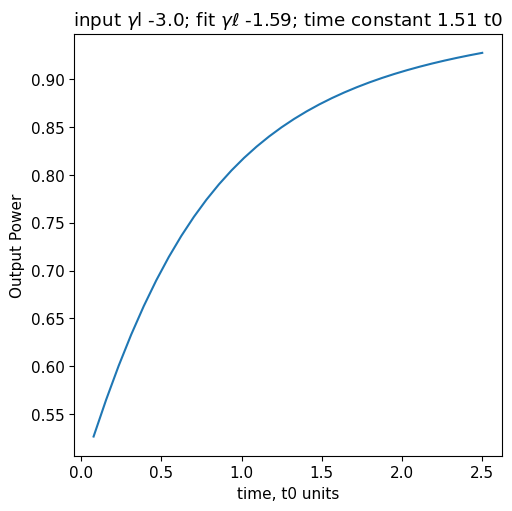

In [11]:
# @title Postprocessing and display output

ampxz_cpu=ampxz.get()
escsxz_cpu=escsxz.get()
ampout_cpu=ampout.get()
#if not abort:
if True:
  #circle to delineate possible direction cosines
  patch=Circle((0,0),radius=1,color='w',fill=False)
  ift_cpu=ift.get()
  if backpropagate:
    imout_cpu=imoutb.get()
  else:
    imout_cpu=imout.get()

  if prdata['timedep']==True:
    # The original shape was incorrect.
    # It should be (jt//4+1, lx, ly) to match the accumulated data.
    # imout_cpu=np.reshape(imout_cpu,(jt//4+1,lx,ly))

    # Calculate the correct first dimension based on imout_cpu's size
    num_frames = imout_cpu.size // (lx * ly)
    imout_cpu = np.reshape(imout_cpu, (num_frames, lx, ly))

    # Apply the same logic to ift_cpu if it has a similar structure
    num_frames_ift = ift_cpu.size // (xsamp * ysamp)
    ift_cpu = np.reshape(ift_cpu, (num_frames_ift, xsamp, ysamp))

  else:
      imout_cpu=np.reshape(imout_cpu,(1,lx,ly))
      ift_cpu=np.reshape(ift_cpu,(1,xsamp,ysamp))

  imout_final=np.rot90(imout_cpu[-1],k=3)
  if abort:
    imout_final=np.rot90(imout_cpu[jt_last_good//4],k=3)
  imin_final=np.rot90(imin,k=3)


if timedep and 'escsfull_cpu' in locals():
  del escsfull_cpu

# ... rest of the code ...

#Display output

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["animation.html"] = "jshtml"

rcParams.update({'font.size': 11})

def func(xx, aa, bb): #exponential gain fit
    return aa * np.exp(-bb * xx) - aa

if timedep==0:
    tsteps=1
lbf=int(xsamp*(1-xaper/yaper*ysamp/xsamp)/2) #assuming yaper<xaper
luf=int(xsamp*(1+xaper/yaper*ysamp/xsamp)/2)


ixz=abs(ampxz_cpu)**2
ixz=np.where(ixz<0.0001,0.0001,ixz)

ixzf=ixz[-1] #not [0]

dx=xaper/xsamp
dy=yaper/ysamp
extent_crop=[dy*yl,dy*yh,dx*xl,dx*xh]
extent_crop=[-im_samp_width/2,im_samp_width/2,-im_samp_height/2,im_samp_height/2]

#fanning_mask
if w01 > 0:
  ws=min(w01,20) #minimum size of mask to cut remaining input beam
else:
    ws = 100

maskxp=int(xaper*(fx1+1/ws/2))+xsamp//2
maskxm=int(xaper*(fx1-1/ws/2))+xsamp//2
maskyp=int(yaper*(fy1+1/ws/2))+ysamp//2
maskym=int(yaper*(fy1-1/ws/2))+ysamp//2

mask=np.ones((xsamp,ysamp))
mask[maskxm:maskxp,maskym:maskyp]=0

def plot_data1(vmin=1,vmout=1,imin=fixed(imin_final),imout=fixed(imout_final)):
  fig1, ax1=plt.subplots(1,2,figsize=(6.8,3.4))
  ax1[0].set_title('input image')
  ax1[0].set_xlabel(r'x ($\mu$m)')
  ax1[0].set_ylabel(r'y ($\mu$m)')

  ax1[1].set_title('output image')
  ax1[1].set_xlabel(r'x ($\mu$m)')
  ax1[1].set_ylabel(r'y ($\mu$m)')

  img=ax1[0].imshow(imin,extent=extent_crop,vmax=vmin)
  cbar=fig1.colorbar(img,location='bottom')

  img=ax1[1].imshow(imout,extent=extent_crop,vmax=vmout)
  cbar=fig1.colorbar(img,location='bottom')
  plt.show(fig1)
  return fig1,vmout

wdisp1=interactive(plot_data1,vmin=widgets.FloatLogSlider(min=-2,max=2,step=0.1,value=1),
  vmout=widgets.FloatSlider(min=0.1,max=2,step=0.1,value=1) )

data1in = abs(amp0m.get()[:,ysamp//2])**2
data2in = abs(amp0p.get()[:,ysamp//2])**2
data1out = abs(ampm.get()[:,ysamp//2])**2
data2out = abs(ampp.get()[:,ysamp//2])**2
if abort:
  ampft=spfft.fft2(ampout[jt_last_good//4-1])
  ampm=spfft.ifft2(ampft*cp.fft.fftshift(mask1))  #beam 1 intensity
  ampp=ampout[jt_last_good//4-1]-ampm  #beam 2 intensity

  data1out = abs(ampm.get()[:,ysamp//2])**2
  data2out = abs(ampp.get()[:,ysamp//2])**2

datax=(data1in,data2in,data1out,data2out)
xax=x.get()

def plot_data2(yinlim=1,youtlim=1,data=fixed(datax),x=fixed(xax)):
  data1in=data[0]
  data2in=data[1]
  data1out=data[2]
  data2out=data[3]
  fig3, ax3 = plt.subplots(1,2 ,figsize=(6.8,3.4))

  ax3[0].set_xlabel(r'x ($\mu$m)')
  ax3[0].set_ylabel('Normalized Intensity')
  ax3[0].plot(x, data1in)

  ax3[0].plot(x, data2in)
  ax3[0].legend(['Beam 1','Beam 2'],loc='upper right')
  ax3[0].set_ylim(0,yinlim)


  #color = 'tab:red'
  ax3[1].set_xlabel(r'x ($\mu$m)')
  ax3[1].set_ylabel('Normalized Intensity')
  ax3[1].plot(x, data1out)
  ax3[1].tick_params(axis='y')
  ax3[1].legend(['Beam 1'],loc='upper left')
  #color = 'tab:blue'
  ax3[1].plot(x, data2out)
  ax3[1].legend(['Beam 1','Beam 2'],loc='upper right')
  ax3[1].set_ylim(0,youtlim)
  plt.show(fig3)
  return fig3,youtlim


ymax_out=5
wdisp3=interactive(plot_data2,yinlim=widgets.FloatSlider(min=0.1,max=2,step=0.1,value=1),
  youtlim=widgets.FloatSlider(min=0.1,max=ymax_out,step=0.1,value=1) )
text_label1=widgets.Label('Interactively adjust color scales with vmin and vmout sliders or values')
text_label3=widgets.Label('Interactively adjust y axis scales with yinlim and youtlim sliders or values')
vbox1=widgets.VBox([text_label1,wdisp1])
vbox3=widgets.VBox([text_label3,wdisp3])
display(vbox1)
display(vbox3)
P_input=np.sum(abs(amp0.get())**2)*dx*dy
#total output power
P_output=np.sum(abs(ampm.get())**2)*dx*dy
#ff_sphr=P_xy_thpi(ift_cpu[-1])/P_inpu

if True:

    faneff=np.sum(mask*ift_cpu,axis=(1,2))/np.sum(ift_cpu,axis=(1,2))
    fanstr='{0:.2f}'.format(faneff[-1])
    ff_out=ift_cpu
    #normalized ft out
    ff_out=ff_out*(dx*dy)**2/P_input





    fanout=mask*ff_out[-1]
    #reminder fanout and ift are in units of spatial frequencies fx and fy
    xx=np.arange(xsamp)
    xm=xsamp/2-np.sum(xx[None,:]*fanout.T)/np.sum(fanout)
    fanroll=np.roll(fanout,int(xm),axis=1)
    fxshift=np.fft.fftshift(fx).get()
    fyshift=np.fft.fftshift(fy).get()
    dfx=fx[1]-fx[0]
    dfy=fy[1]-fy[0]
    frad=np.sqrt(fxshift[None,:]**2+fyshift[:,None]**2)
    rad=np.sum(frad*fanroll.T)/np.sum(fanroll)
    mean_fan=np.sum(fanout)*dfx*dfy*np.pi/(rad**2)




    sx=lm*fx.get()
    sy=lm*fy.get()
    dsx=sx[1]-sx[0]
    dsy=sy[1]-sy[0]
    output_direction_cosines=ff_out/lm**2
    extent_s=[lm*fxshift[0],lm*fxshift[-1],lm*fyshift[0],lm*fyshift[-1]]
    iroll=np.argmin(abs(np.fft.fftshift(sx)+np.sin(thout1)))




    def plot_fan(far_field_max=mean_fan,data1=fixed(output_direction_cosines[-1].T),extent=fixed(extent_s),fx1=fixed(fx1)):
      fig,ax = plt.subplots() #output far field
      ax.set_xlabel( r'x direction cosine')
      ax.set_ylabel( r'y direction cosine')
      ax.set_title( r'far field $\gamma \ell$ '+str(prdata['gl']))
      img=ax.imshow(data1,
                     extent=extent_s,vmax=far_field_max)

      patch=Circle((0,0),radius=1,color='w',fill=False)
      ax.add_patch(patch)
      cbar=fig.colorbar(img,location='bottom',label='Normalized Power')
      plt.show(fig)
      return fig,far_field_max

    wdisp4=interactive(plot_fan,far_field_max=widgets.FloatSlider(min=mean_fan/10,max=mean_fan*2,step=0.1,value=mean_fan))
    display(wdisp4)


extent=[0,prdata['rlen']/1000,-xaper/2000,xaper/2000]
if abort:
  ixz_plot=ixz[jt_last_good//4]
else:
  ixz_plot=ixz[-1]
def plot_xsection(xsecmax=1,data1=fixed(ixz_plot.T),extent=fixed(extent)):
  fig,ax = plt.subplots() #output far field
  ax.set_xlabel( r'z (mm)')
  ax.set_ylabel( r'x (mm)')
  ax.set_title( r'cross section linear scale $\gamma \ell$ '+str(prdata['gl']))
  img=ax.imshow(data1,extent=extent,vmax=xsecmax)#,cmap='terrain')
  cbar=fig.colorbar(img,location='bottom')
  plt.show(fig)
  return fig,xsecmax
value_def=2
wdisp5=interactive(plot_xsection,xsecmax=widgets.FloatSlider(min=value_def/8,max=value_def,step=0.01,value=value_def/2))
display(wdisp5)
if abort:
  escs_plot=escsxz_cpu[jt_last_good//4]
else:
  escs_plot=escsxz_cpu[-1]
def plot_esc_section(esc_max=1,data1=fixed(abs(escs_plot.T)),extent=fixed(extent)):
  fig,ax = plt.subplots() #output far field
  ax.set_xlabel( r'z (mm)')
  ax.set_ylabel( r'x (mm)')
  ax.set_title( r'grating field $\gamma \ell$ '+str(prdata['gl']))
  img=ax.imshow(data1,extent=extent,vmax=esc_max)#,cmap='terrain')
  cbar=fig.colorbar(img,location='bottom')
  plt.show(fig)
  return fig,esc_max
wdisp6=interactive(plot_esc_section,esc_max=widgets.FloatSlider(min=.1,max=1.5,step=0.01,value=0.5))
display(wdisp6)

if prdata['timedep']==True:


  if not fanning_study:
    imout_power=np.sum(imout_cpu[-1])
    fig0 = plt.figure(figsize=(5, 5), dpi=100)
    ax6=fig0.add_subplot()
    ax6.set_xlabel('time, t0 units')
    ax6.set_ylabel('Output Power')
    #ax6.plot(t_seq.get(),gain_seq.get())
    ax6.plot(t_seq.get(),imr_norm.get())
    popt, pcov = curve_fit(func, t_seq.get(), gain_seq.get())
    tcstr='{0:.2f}'.format(1/popt[1])
    gstr='{0:.2f}'.format(-popt[0])

    ax6.set_title( r'input $\gamma$l '+str(gl)+'; fit $\gamma \ell$ ' +gstr+ '; time constant '+tcstr+ ' t0' )
    plt.show(fig0)
    #print('popt,pcov',popt,pcov)
  else:
    fig0,ax = plt.subplots()
    ax.plot(t_seq.get()[::4],faneff)
    ax.set_xlabel('time, t0 units')
    ax.set_ylabel('Fanning Output Power')
    ax.set_title( r' $\gamma \ell$ '+str(prdata['gl'])+' waist '+str(prdata['w01'])+' $\mu m$ ')
    plt.show(fig0)




In [14]:
# @title code to enable movie generation
dict_movie=prdata
#temporary google files
pathf_temp='/content/drive/MyDrive/temp_files/'
if not Path(pathf_temp).is_dir():
  Path.mkdir(Path(pathf_temp))
out_file = open(pathf_temp+"dict_movie.json", "w")
dict_movie['extent_s']=extent_s
dict_movie['extent_crop']=extent_crop
dict_movie['sx']=sx.tolist()
dict_movie['wdisp5']=wdisp5.result[1]
dict_movie['wdisp4']=wdisp4.result[1]
dict_movie['wdisp1']=wdisp1.result[1]
dict_movie['wdisp3']=wdisp3.result[1]
dict_movie['jt_last_good']=jt_last_good
dict_movie['abort']=abort


json.dump(dict_movie, out_file,indent=4)
out_file.close()
np.savez(pathf_temp+'movie_data.npz',output_direction_cosines=output_direction_cosines,ixz=ixz,
          imout_cpu=imout_cpu,sx=sx)
# end movie generation code

In [10]:
# @title Save data save data box checked
# save data if called for
if savedata:

  fig1=wdisp1.result[0]
  fig3=wdisp3.result[0]

  fig5=wdisp5.result[0]
  fig6=wdisp6.result[0]


  plt.figure(fig1)
  plt.savefig(pathf+'/image_in_out.png',bbox_inches='tight')


  plt.figure(fig3)
  plt.savefig(pathf+'/intensity_trace.png',bbox_inches='tight')
  plt.close()
  plt.figure(fig5)
  plt.savefig(pathf+'/cross_section.png',bbox_inches='tight')
  plt.close()
  plt.figure(fig6)
  plt.savefig(pathf+'/grating_field.png',bbox_inches='tight')
  plt.close()
  with open(pathf+'/data.json', 'w') as f:
    json.dump(prdata, f,indent=4)


  fylo=max(-0.6,-fymax)
  fyhi=min(0.6,fymax)
  fxlo=max(-0.6,-fxmax)
  fxhi=min(0.6,fxmax)
  xpxmin=int(fxlo*xaper+xsamp/2)
  xpxmax=int(fxhi*xaper+xsamp/2-1)
  ypxmin=int(fylo*yaper+ysamp/2)
  ypxmax=int(fyhi*yaper+ysamp/2-1)

  if True:
    fig4=wdisp4.result[0]
    plt.figure(fig4)
    plt.savefig(pathf+'/farfield.png',bbox_inches='tight')
    plt.close()
    iftmasked=mask*ift_cpu[-1]

    fig,ax = plt.subplots()
    ax.set_xlabel( 'x direction cosine')
    ax.set_ylabel('y direction cosine')
    ax.set_title( r'far field $\gamma \ell$ '+str(prdata['gl']))



    img=ax.imshow(np.roll(output_direction_cosines[-1].T,-iroll-xsamp//2,axis=1),extent=extent_s
                ,vmax=wdisp4.result[1])
    ax.set_xlim([(-0.02),(min(0.72,extent_s[1]))])

    ylimit=min(0.25,extent_s[3])
    ax.set_ylim([-ylimit,ylimit])
    cx,cy=0,0
    patch=Circle((0,0),radius=1,color='w',fill=False)
    ax.add_patch(patch)
    plt.figure(fig)
    plt.savefig(pathf+'/ffcompact.png',bbox_inches='tight')
    plt.close()

  if not fanning_study and timedep:
    plt.figure(fig0)
    plt.savefig(pathf+'/time_graph.png',bbox_inches='tight')
    plt.close()



  if timedep and fanning_study:
    fig,ax = plt.subplots()
    ax.plot(t_seq.get()[::4],faneff)
    ax.set_xlabel('time, t0 units')
    ax.set_ylabel('Fanning Output Power')
    ax.set_title( r' $\gamma \ell$ '+str(prdata['gl'])+' waist '+str(prdata['w01'])+' $\mu m$ ')
    plt.savefig(pathf+'/time_graph.png',bbox_inches='tight')



In [11]:

  if timedep and fanning_study:
    fig,ax = plt.subplots()
    ax.plot(t_seq.get()[::4],faneff)
    ax.set_xlabel('time, t0 units')
    ax.set_ylabel('Fanning Output Power')
    ax.set_title( r' $\gamma \ell$ '+str(prdata['gl'])+' waist '+str(prdata['w01'])+' $\mu m$ ')
    plt.savefig(pathf+'/time_graph.png',bbox_inches='tight')



Special code for analyzing time constants from Horowitz et al J. Opt. Soc. Am B vol. 8 p. 2204 (1991)

In [ ]:
#p278=imr_norm.get()*(1+rat*np.exp(-2*2.644))/(1+rat*np.exp(2*gl))
#p330=imr_norm.get()*(1+rat*np.exp(-2*3.139))/(1+rat*np.exp(2*gl))
#p172=imr_norm.get()*(1+rat*np.exp(-2*1.636))/(1+rat*np.exp(2*gl))

In [ ]:
#plt.plot(t_seq.get()*(1+(kg/k0)**2),p172, colo in r='r')
#plt.plot(t_seq.get()*(1+(kg/k0)**2),p278,color='b')
#plt.plot(t_seq.get()*(1+(kg/k0)**2),p330,color='g')
#plt.ylim(0,1)
#plt.xlabel('time, t0/(1+$(k_g/k_0)^2$) units')
#plt.ylabel('Normalized Output Power')
#plt.legend(['$\gamma \ell$ = 1.72','$\gamma \ell$ = 2.78','$\gamma \ell$ = 3.3'])
#plt.plot()